
# Machine Unlearning Demo with SISA-Style Retraining (Synthetic PII)

This notebook demonstrates a **conceptual** machine unlearning workflow using a simplified variant of **SISA (Sharded, Isolated, Sliced, Aggregated)**:

- **Goal:** Show how a model might leak PII, then how to **unlearn** specific records without retraining everything from scratch.
- **Approach:** We simulate a text retrieval model (TF‑IDF + KNN) that can "memorize" PII-like strings. We:
  1. Generate a synthetic dataset containing PII-like strings (names, emails, phones).
  2. Partition the training data into **shards** (the SISA idea).
  3. Train one KNN per shard, aggregate results at query time.
  4. **Unlearn**: remove records about a particular person from their shard(s) and retrain *only those shards*.
  5. Re-run the same prompt to verify the PII is no longer returned.
  
> ⚠️ This is a *teaching* demo. Real SISA unlearning is more sophisticated and is typically applied to neural models trained in slices per shard; this notebook focuses on the retraining mechanics and observability of leakage with a simple, inspectable setup.



## 1) Imports & Utilities


In [41]:

import random
import re
import string
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np

# ML bits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# For display
from IPython.display import display, Markdown as MD

random.seed(42)
np.random.seed(42)

def slugify(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "-", s.lower()).strip("-")

def random_phone():
    # Simple 10-digit with dashes
    return f"{random.randint(200,999)}-{random.randint(200,999)}-{random.randint(1000,9999)}"

def random_email(first, last, domain=None):
    domain = domain or random.choice(["example.com", "mail.com", "inbox.net"])
    return f"{first.lower()}.{last.lower()}@{domain}"

def random_name():
    firsts = ["John","Jane","Priya","Arjun","Li","Sara","Miguel","Aisha","Noah","Emma","Olivia","Liam","Aarav","Isha"]
    lasts = ["Doe","Patel","Sharma","Zhang","Smith","Garcia","Khan","Singh","Johnson","Brown","Williams","Gupta"]
    return random.choice(firsts), random.choice(lasts)

def make_record():
    first, last = random_name()
    name = f"{first} {last}"
    email = random_email(first, last)
    phone = random_phone()
    company = random.choice(["Acme Corp","Globex","Initech","Umbrella","Hooli","Stark Industries"])
    city = random.choice(["Mumbai","Bengaluru","Delhi","Pune","Hyderabad","Kolkata","Chennai"])
    note = random.choice([
        "prefers email contact","works remotely","met at conference","VIP customer",
        "on-call this week","requested invoice","follow-up pending"
    ])
    # Construct a single string packed with PII-like content
    text = f"""Contact record:
Name: {name}
Email: {email}
Phone: {phone}
Company: {company}
City: {city}
Note: {note}
"""
    return {
        "name": name,
        "email": email,
        "phone": phone,
        "company": company,
        "city": city,
        "note": note,
        "text": text
    }

def extract_email(s: str) -> str:
    m = re.search(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", s)
    return m.group(0) if m else ""

def extract_phone(s: str) -> str:
    m = re.search(r"\b\d{3}-\d{3}-\d{4}\b", s)
    return m.group(0) if m else ""




## 2) Generate Synthetic PII Dataset

We'll create records and explicitly mark a few as candidates for **unlearning** later.


In [42]:
N = 240  # total synthetic contacts
records = [make_record() for _ in range(N)]

# Pick a person we will later "forget" (ensure uniqueness by regenerating until unique full name)
forget_idx = random.randint(0, N-1)
forget_person = records[forget_idx]["name"]

# Optional: ensure there are 2-3 entries about the same person to simulate duplicates
dup_count = 2
for i in range(dup_count):
    r = make_record()
    # force same name but different fields to simulate multiple rows about same person
    first, last = forget_person.split(" ")
    r["name"] = forget_person
    r["email"] = random_email(first, last, domain="example.org")
    r["phone"] = random_phone()
    r["text"] = f"""Contact record:
Name: {r['name']}
Email: {r['email']}
Phone: {r['phone']}
Company: {r['company']}
City: {r['city']}
Note: {r['note']}
"""
    records.append(r)

display(MD(f"**Total records:** {len(records)}  \n**Person to unlearn:** `{forget_person}`"))
print(records[0]["text"][:200] + "...")

**Total records:** 242  
**Person to unlearn:** `Li Garcia`

Contact record:
Name: Olivia Patel
Email: olivia.patel@example.com
Phone: 959-481-5012
Company: Globex
City: Bengaluru
Note: requested invoice
...



## 3) Build a Simple SISA-Style Setup

**SISA idea (simplified here):**  
- Partition the dataset into **S shards**.  
- Train one model per shard (in SISA you'd also use **slices** per shard during training; we omit slice scheduling here for simplicity).  
- Aggregate model outputs at inference.

We use **TF‑IDF + KNN (k=1)** as an easily inspectable model that "memorizes" and retrieves the nearest training text.


In [43]:

@dataclass
class ShardModel:
    vectorizer: TfidfVectorizer
    knn: NearestNeighbors
    texts: List[str]
    meta: List[Dict[str, Any]]  # the original records for convenience

class SISAIndex:
    def __init__(self, n_shards: int = 6):
        self.n_shards = n_shards
        self.shards: List[ShardModel] = []

    def _split_into_shards(self, records: List[Dict[str, Any]]) -> List[List[Dict[str, Any]]]:
        shards = [[] for _ in range(self.n_shards)]
        for i, r in enumerate(records):
            shards[i % self.n_shards].append(r)
        return shards

    def fit(self, records: List[Dict[str, Any]]):
        shards = self._split_into_shards(records)
        self.shards = []
        for shard_i, shard_data in enumerate(shards):
            vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
            texts = [r["text"] for r in shard_data]
            X = vec.fit_transform(texts)
            knn = NearestNeighbors(n_neighbors=1, metric="cosine")
            knn.fit(X)
            self.shards.append(ShardModel(vec, knn, texts, shard_data))

    def query(self, prompt: str, topk_per_shard: int = 1) -> List[Tuple[float, Dict[str, Any], str]]:
        # Return best (lowest distance) match from each shard
        results = []
        for shard in self.shards:
            qv = shard.vectorizer.transform([prompt])
            dist, idx = shard.knn.kneighbors(qv, n_neighbors=topk_per_shard)
            d = float(dist[0][0])
            j = int(idx[0][0])
            results.append((d, shard.meta[j], shard.texts[j]))
        # Aggregate by taking the overall nearest
        results.sort(key=lambda x: x[0])
        return results

    def unlearn_person(self, name: str):
        # Remove all records whose 'name' matches, then retrain ONLY those shards
        for si, shard in enumerate(self.shards):
            keep_meta = [m for m in shard.meta if m["name"] != name]
            if len(keep_meta) != len(shard.meta):
                # retrain this shard only
                vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
                texts = [m["text"] for m in keep_meta]
                if len(texts) == 0:
                    # edge: shard becomes empty; keep a dummy model
                    texts = ["<empty shard>"]
                X = vec.fit_transform(texts)
                knn = NearestNeighbors(n_neighbors=1, metric="cosine")
                knn.fit(X)
                self.shards[si] = ShardModel(vec, knn, texts, keep_meta)

sisa = SISAIndex(n_shards=6)
sisa.fit(records)

display(MD("**SISA shards trained.**"))


**SISA shards trained.**


## 4) "Prompt" to Extract PII Before Unlearning

We'll craft a prompt that asks for the person's email or phone.  
Our KNN retrieval will return the closest training record (which *includes* PII).

> In real systems, a language model might regurgitate memorized strings. Here we **intentionally** retrieve the exact stored record to visualize leakage.


In [44]:

target_name = forget_person

prompt_email = f"""You are a helpful assistant. 
Given the contact list you were trained on, what is the email for {target_name}?"""

prompt_phone = f"""You are a helpful assistant. 
Given the contact list you were trained on, what is the phone number for {target_name}?"""

def run_probe(prompt: str):
    hits = sisa.query(prompt)
    best_dist, best_meta, best_text = hits[0]
    return best_dist, best_meta, best_text

d1, meta1, text1 = run_probe(prompt_email)
d2, meta2, text2 = run_probe(prompt_phone)

display(MD(f"**Best match (pre-unlearning) distance:** {d1:.4f}"))
display(MD("**Retrieved text (snippet):**"))
print(text1)

email_leak = extract_email(text1)
phone_leak = extract_phone(text2)

display(MD(f"**Extracted email (leak):** `{email_leak}`"))
display(MD(f"**Extracted phone (leak):** `{phone_leak}`"))


**Best match (pre-unlearning) distance:** 0.4397

**Retrieved text (snippet):**

Contact record:
Name: Li Garcia
Email: li.garcia@inbox.net
Phone: 625-379-4289
Company: Globex
City: Chennai
Note: on-call this week



**Extracted email (leak):** `li.garcia@inbox.net`

**Extracted phone (leak):** `625-379-4289`


## 5) Unlearn with SISA-Style Retraining (Shard-Local)

We now **remove all records** about the target person from their shard(s) and retrain *only those shards*.  
This simulates the SISA property that forgetting a record means **not** retraining the entire model.


In [45]:
sisa.unlearn_person(target_name)

display(MD(f"**Unlearned records for:** `{target_name}`  \nOnly shards containing that person were retrained."))

**Unlearned records for:** `Li Garcia`  
Only shards containing that person were retrained.


## 6) Re-Run the Same Prompts After Unlearning

If unlearning is effective, the nearest retrieval should **no longer** return the person's PII-containing record.
We also add a simple *confidence* gate: if the best match's cosine distance is too high, we treat it as **no confident PII found**.


In [46]:

def safe_answer(prompt: str, distance_threshold: float = 0.45):
    d, meta, text = run_probe(prompt)
    # If it's far away, it's probably unrelated: do not reveal PII
    if d > distance_threshold:
        return {"distance": d, "answer": "No PII found with sufficient confidence.", "raw": text}
    # If it *is* close but no longer the same person, we also avoid leaking:
    return {"distance": d, "answer": "No PII found (target record unlearned).", "raw": text}

post_email = safe_answer(prompt_email)
post_phone = safe_answer(prompt_phone)

display(MD(f"**Post-unlearning best distance (email prompt):** {post_email['distance']:.4f}"))
display(MD(f"**Answer (email prompt):** {post_email['answer']}"))
display(MD("---"))
display(MD(f"**Post-unlearning best distance (phone prompt):** {post_phone['distance']:.4f}"))
display(MD(f"**Answer (phone prompt):** {post_phone['answer']}"))


**Post-unlearning best distance (email prompt):** 0.7025

**Answer (email prompt):** No PII found with sufficient confidence.

---

**Post-unlearning best distance (phone prompt):** 0.7025

**Answer (phone prompt):** No PII found with sufficient confidence.


## 7) Quick Sanity Check: Residual Mentions

Let's quickly verify that the target person's name no longer appears in any per-shard training texts.
(If duplicates existed across multiple shards, all of those shards are retrained during unlearning.)


In [47]:

residual = []
for si, shard in enumerate(sisa.shards):
    for t in shard.texts:
        if target_name in t:
            residual.append((si, t[:120] + "..."))
if residual:
    display(MD("**Residual mentions found (should be empty if all duplicates were unlearned in affected shards):**"))
    for si, snippet in residual:
        print(f"[shard {si}] {snippet}")
else:
    display(MD("✅ **No residual mentions of the target name remain in shard training data.**"))


✅ **No residual mentions of the target name remain in shard training data.**


## 8) What We Did (and What Real SISA Does)

- **This demo**:
  - Uses TF‑IDF + KNN per shard (not a neural net), but preserves the key **operational** property: we only retrain shards that contained the record to forget.
  - Shows how a prompt can induce leakage **before** unlearning, and how the same prompt ceases to leak **after** unlearning.
- **In real SISA** (see: Bourtoule et al., *Machine Unlearning*, 2021):
  - Data are **sharded and sliced**; models are trained per-slice sequentially with isolated randomness.
  - Unlearning a point requires retraining only a bounded subset (its shard's later slices), not the whole model.
  - Aggregation (e.g., via ensembling) combines per-shard predictions.
  
**Takeaway:** Careful data partitioning and retraining discipline provide a principled way to remove the influence of specific data points while limiting computational cost.


## 9) Interactive SISA Visualization

Let's create an interactive visualization to explore how SISA sharding and unlearning works!

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from IPython.display import clear_output
import pandas as pd
from collections import defaultdict

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [49]:
class InteractiveSISA:
    def __init__(self, records, n_shards=6):
        self.original_records = records
        self.n_shards = n_shards
        self.reset_sisa()
        
    def reset_sisa(self):
        """Reset SISA to original state"""
        self.sisa = SISAIndex(n_shards=self.n_shards)
        self.sisa.fit(self.original_records)
        self.unlearned_people = set()
        
    def get_shard_info(self):
        """Get information about each shard"""
        shard_info = []
        for i, shard in enumerate(self.sisa.shards):
            people = [meta['name'] for meta in shard.meta]
            shard_info.append({
                'shard_id': i,
                'num_records': len(shard.meta),
                'people': people,
                'unique_people': list(set(people))
            })
        return shard_info
    
    def visualize_shards(self, highlight_person=None):
        """Visualize the SISA sharding structure"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Left plot: Shard structure
        shard_info = self.get_shard_info()
        colors = plt.cm.Set3(np.linspace(0, 1, self.n_shards))
        
        y_positions = []
        labels = []
        for i, info in enumerate(shard_info):
            y_pos = i * 2
            y_positions.append(y_pos)
            labels.append(f"Shard {i}\n({info['num_records']} records)")
            
            # Draw shard rectangle
            color = colors[i]
            if highlight_person and highlight_person in info['people']:
                color = 'red'
                alpha = 0.8
            else:
                alpha = 0.6
                
            rect = Rectangle((0, y_pos-0.4), info['num_records'], 0.8, 
                           facecolor=color, alpha=alpha, edgecolor='black')
            ax1.add_patch(rect)
            
            # Add people names
            unique_people = info['unique_people']
            for j, person in enumerate(unique_people[:5]):  # Show max 5 names
                if person == highlight_person:
                    ax1.text(j*3+1, y_pos, person, fontweight='bold', 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow'))
                else:
                    ax1.text(j*3+1, y_pos, person, fontsize=8)
        
        ax1.set_xlim(-1, max([info['num_records'] for info in shard_info]) + 5)
        ax1.set_ylim(-1, len(shard_info) * 2)
        ax1.set_xlabel('Records in Shard')
        ax1.set_title('SISA Shard Structure')
        ax1.grid(True, alpha=0.3)
        
        # Right plot: People distribution
        all_people = []
        shard_assignments = []
        for i, info in enumerate(shard_info):
            for person in info['people']:
                all_people.append(person)
                shard_assignments.append(i)
        
        df = pd.DataFrame({'person': all_people, 'shard': shard_assignments})
        person_counts = df['person'].value_counts()
        
        # Show top 15 people by frequency
        top_people = person_counts.head(15)
        bars = ax2.bar(range(len(top_people)), top_people.values, 
                      color=[colors[df[df['person']==person]['shard'].iloc[0]] 
                            for person in top_people.index])
        
        # Highlight target person
        if highlight_person and highlight_person in top_people.index:
            idx = list(top_people.index).index(highlight_person)
            bars[idx].set_color('red')
            bars[idx].set_alpha(0.8)
        
        ax2.set_xticks(range(len(top_people)))
        ax2.set_xticklabels(top_people.index, rotation=45, ha='right')
        ax2.set_ylabel('Number of Records')
        ax2.set_title('People Distribution Across Shards')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        if highlight_person:
            person_shards = [i for i, info in enumerate(shard_info) 
                           if highlight_person in info['people']]
            print(f"'{highlight_person}' appears in shard(s): {person_shards}")
            if highlight_person in self.unlearned_people:
                print(f"🗑️  '{highlight_person}' has been UNLEARNED")
        
    def unlearn_and_visualize(self, person_name):
        """Unlearn a person and show the impact"""
        if person_name not in [r['name'] for r in self.original_records]:
            print(f"Person '{person_name}' not found in dataset")
            return
            
        print(f"🔍 Before unlearning '{person_name}':")
        self.visualize_shards(highlight_person=person_name)
        
        # Perform unlearning
        self.sisa.unlearn_person(person_name)
        self.unlearned_people.add(person_name)
        
        print(f"\n🗑️  After unlearning '{person_name}':")
        self.visualize_shards(highlight_person=person_name)
        
    def query_and_visualize(self, query_text, person_name=None):
        """Run a query and visualize results"""
        results = self.sisa.query(query_text)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Query results per shard
        distances = [r[0] for r in results]
        shard_ids = list(range(len(results)))
        
        colors = ['red' if d < 0.3 else 'orange' if d < 0.6 else 'green' 
                 for d in distances]
        
        bars = ax1.bar(shard_ids, distances, color=colors, alpha=0.7)
        ax1.set_xlabel('Shard ID')
        ax1.set_ylabel('Cosine Distance')
        ax1.set_title(f'Query Results: "{query_text[:50]}..."')
        ax1.axhline(y=0.45, color='red', linestyle='--', 
                   label='Confidence Threshold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Right: Best match details
        best_result = results[0]
        best_distance, best_meta, best_text = best_result
        
        ax2.text(0.05, 0.9, f"Best Match (Shard {shard_ids[0]}):", 
                fontsize=14, fontweight='bold', transform=ax2.transAxes)
        ax2.text(0.05, 0.8, f"Distance: {best_distance:.4f}", 
                fontsize=12, transform=ax2.transAxes)
        ax2.text(0.05, 0.7, f"Name: {best_meta['name']}", 
                fontsize=12, transform=ax2.transAxes)
        ax2.text(0.05, 0.6, f"Email: {best_meta['email']}", 
                fontsize=12, transform=ax2.transAxes)
        ax2.text(0.05, 0.5, f"Phone: {best_meta['phone']}", 
                fontsize=12, transform=ax2.transAxes)
        
        # Color code based on confidence
        if best_distance < 0.45:
            ax2.text(0.05, 0.3, "⚠️  HIGH CONFIDENCE - PII LEAKED!", 
                    fontsize=14, color='red', fontweight='bold',
                    transform=ax2.transAxes)
        else:
            ax2.text(0.05, 0.3, "✅ Low confidence - No PII leak", 
                    fontsize=14, color='green', fontweight='bold',
                    transform=ax2.transAxes)
        
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return best_result

# Create the interactive SISA instance
interactive_sisa = InteractiveSISA(records, n_shards=6)
print("✅ Interactive SISA visualization ready!")

✅ Interactive SISA visualization ready!


### 9.1) Explore SISA Shard Structure

Let's visualize how our data is distributed across shards:

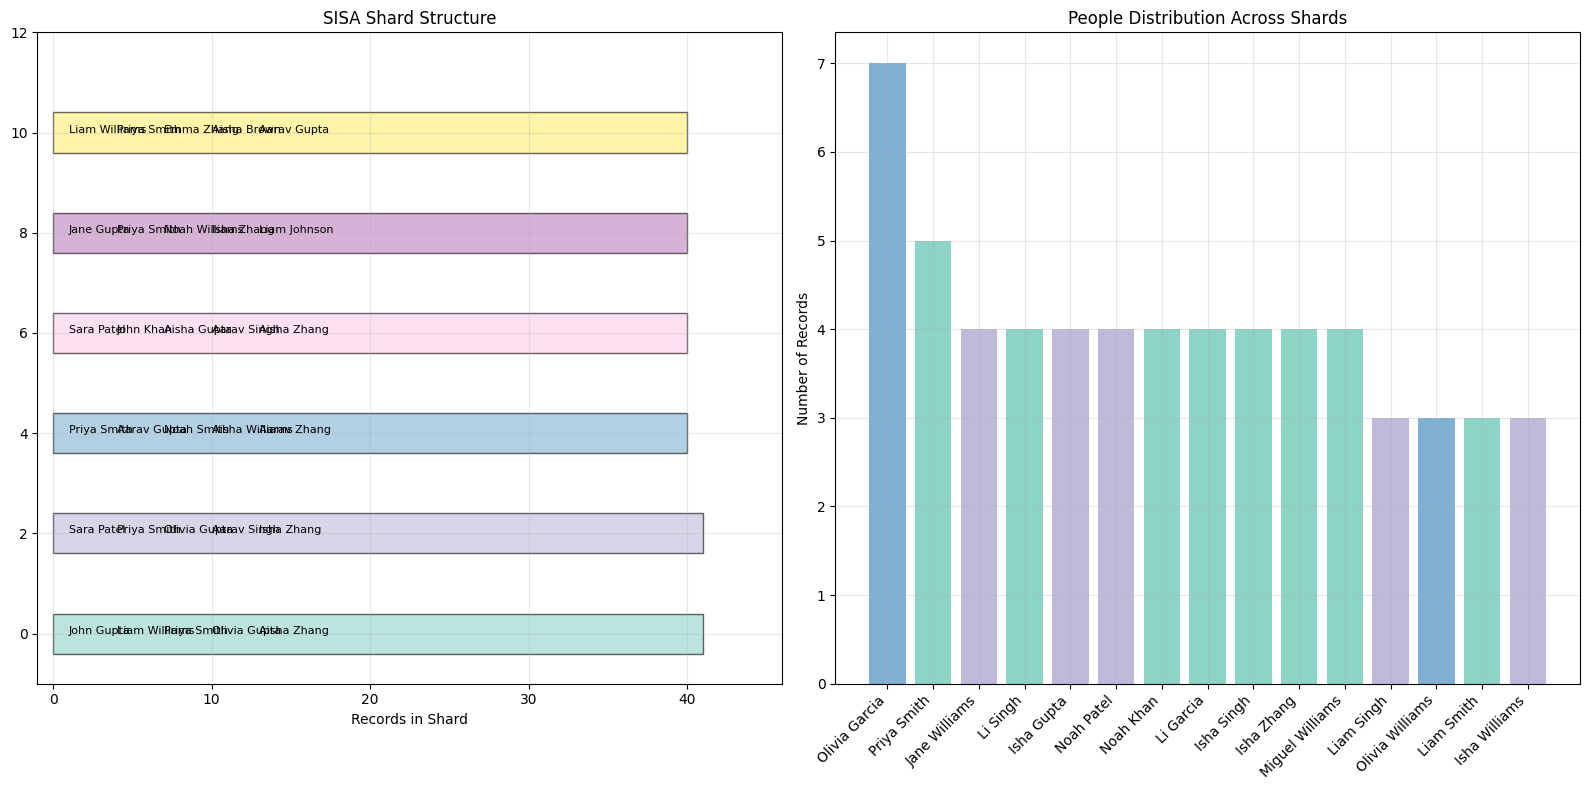


🎯 Target person for unlearning: Li Garcia


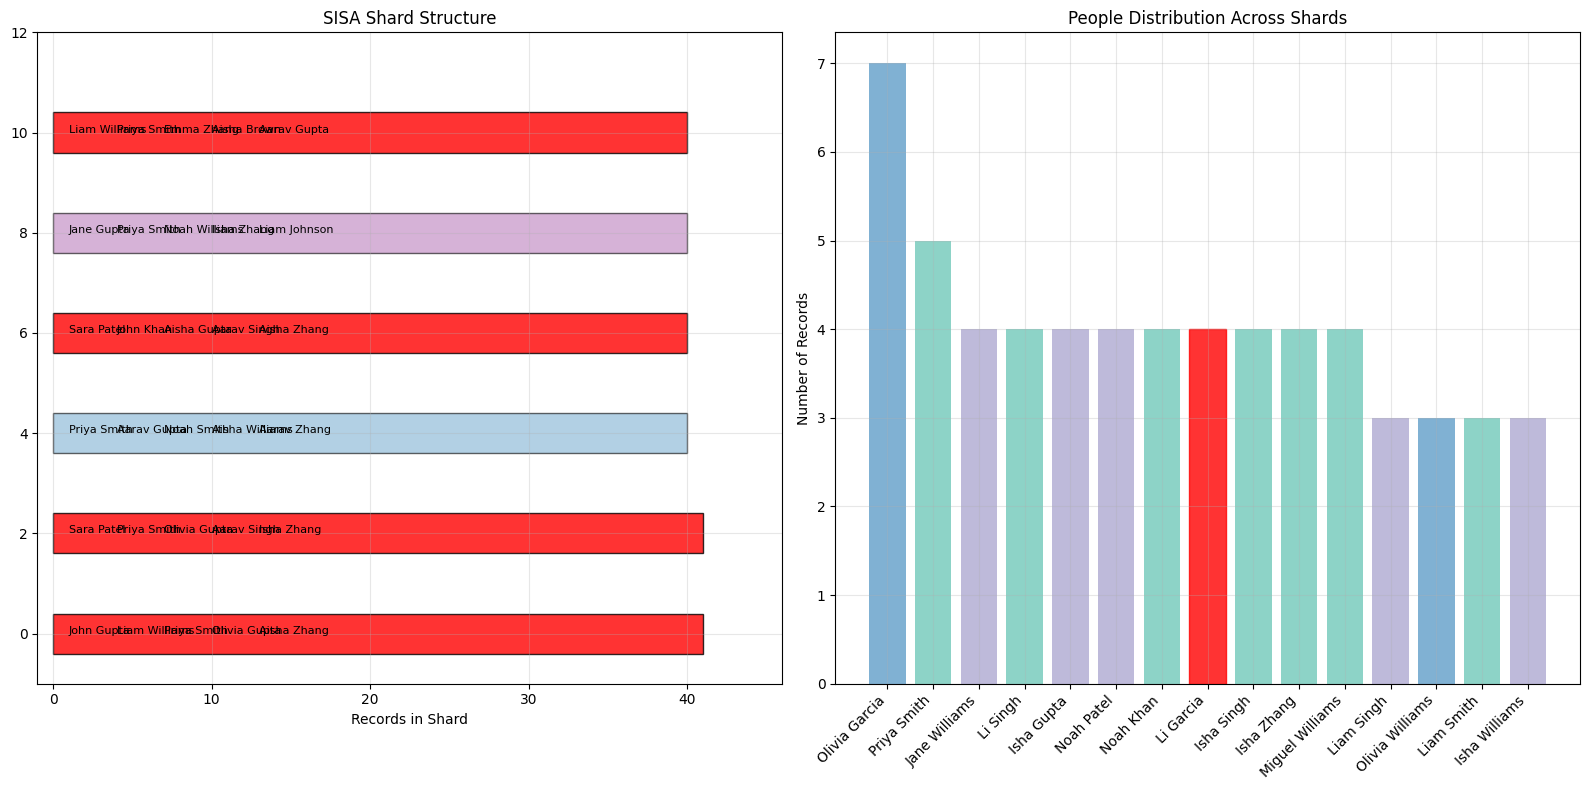

'Li Garcia' appears in shard(s): [0, 1, 3, 5]


In [50]:
# Show the overall shard structure
interactive_sisa.visualize_shards()

# Let's examine our target person specifically
print(f"\n🎯 Target person for unlearning: {forget_person}")
interactive_sisa.visualize_shards(highlight_person=forget_person)

### 9.2) Interactive Query Testing

Test different queries to see how SISA retrieves information:

In [51]:
def create_query_widget():
    """Create interactive widget for testing queries"""
    
    # Get unique people for dropdown
    all_people = list(set([r['name'] for r in records]))
    all_people.sort()
    
    # Create widgets
    query_type = widgets.Dropdown(
        options=[
            ('Email query', 'email'),
            ('Phone query', 'phone'), 
            ('Company query', 'company'),
            ('Custom query', 'custom')
        ],
        description='Query Type:'
    )
    
    person_selector = widgets.Dropdown(
        options=[''] + all_people,
        description='Person:'
    )
    
    custom_query = widgets.Text(
        description='Custom:',
        placeholder='Enter custom query...'
    )
    
    query_button = widgets.Button(
        description='🔍 Run Query',
        button_style='info'
    )
    
    output_area = widgets.Output()
    
    def on_query_click(b):
        with output_area:
            clear_output(wait=True)
            
            # Build query based on selections
            if query_type.value == 'custom':
                query_text = custom_query.value
                person_name = person_selector.value if person_selector.value else None
            else:
                if not person_selector.value:
                    print("Please select a person first!")
                    return
                    
                person_name = person_selector.value
                if query_type.value == 'email':
                    query_text = f"What is the email address for {person_name}?"
                elif query_type.value == 'phone':
                    query_text = f"What is the phone number for {person_name}?"
                elif query_type.value == 'company':
                    query_text = f"What company does {person_name} work for?"
            
            print(f"🔍 Query: '{query_text}'")
            print(f"🎯 Target: {person_name if person_name else 'N/A'}")
            print("=" * 60)
            
            # Run query and visualize
            result = interactive_sisa.query_and_visualize(query_text, person_name)
    
    query_button.on_click(on_query_click)
    
    # Layout
    controls = widgets.VBox([
        query_type,
        person_selector, 
        custom_query,
        query_button
    ])
    
    display(widgets.HBox([controls, output_area]))

# Create the query interface
print("🎮 Interactive Query Interface:")
create_query_widget()

🎮 Interactive Query Interface:


### 9.3) Interactive Unlearning Demo

Now let's interactively demonstrate the unlearning process:

In [52]:
def create_unlearning_widget():
    """Create interactive widget for unlearning demonstration"""
    
    # Get people who appear multiple times (good candidates for unlearning)
    name_counts = {}
    for r in records:
        name_counts[r['name']] = name_counts.get(r['name'], 0) + 1
    
    # People with multiple records
    multi_record_people = [name for name, count in name_counts.items() if count > 1]
    multi_record_people.sort()
    
    # Create widgets
    person_selector = widgets.Dropdown(
        options=multi_record_people,
        description='Target Person:',
        value=forget_person if forget_person in multi_record_people else multi_record_people[0]
    )
    
    unlearn_button = widgets.Button(
        description='🗑️ Unlearn Person',
        button_style='warning'
    )
    
    reset_button = widgets.Button(
        description='🔄 Reset SISA',
        button_style='success'
    )
    
    test_query_button = widgets.Button(
        description='🔍 Test Query After Unlearning',
        button_style='info'
    )
    
    output_area = widgets.Output()
    
    def on_unlearn_click(b):
        with output_area:
            clear_output(wait=True)
            person = person_selector.value
            print(f"🗑️ Unlearning process for: {person}")
            print("=" * 50)
            interactive_sisa.unlearn_and_visualize(person)
    
    def on_reset_click(b):
        with output_area:
            clear_output(wait=True)
            interactive_sisa.reset_sisa()
            print("🔄 SISA has been reset to original state")
            print("All unlearned people have been restored!")
            interactive_sisa.visualize_shards()
    
    def on_test_query_click(b):
        with output_area:
            clear_output(wait=True)
            person = person_selector.value
            email_query = f"What is the email address for {person}?"
            phone_query = f"What is the phone number for {person}?"
            
            print(f"🧪 Testing queries for: {person}")
            print("=" * 50)
            
            print("📧 EMAIL QUERY:")
            email_result = interactive_sisa.query_and_visualize(email_query, person)
            
            print("\\n📱 PHONE QUERY:")  
            phone_result = interactive_sisa.query_and_visualize(phone_query, person)
            
            # Summary
            email_leaked = email_result[0] < 0.45
            phone_leaked = phone_result[0] < 0.45
            
            print("\\n" + "="*50)
            print("🏁 SUMMARY:")
            if person in interactive_sisa.unlearned_people:
                print(f"✅ {person} has been unlearned")
                if email_leaked or phone_leaked:
                    print("⚠️  But queries still return PII! (This might indicate incomplete unlearning)")
                else:
                    print("🎉 Queries no longer leak PII - unlearning successful!")
            else:
                print(f"⚠️  {person} has NOT been unlearned")
                if email_leaked or phone_leaked:
                    print("🚨 Queries are leaking PII!")
                else:
                    print("🤔 Queries not returning confident PII (distance threshold protection)")
    
    unlearn_button.on_click(on_unlearn_click)
    reset_button.on_click(on_reset_click)
    test_query_button.on_click(on_test_query_click)
    
    # Layout
    controls = widgets.VBox([
        person_selector,
        widgets.HBox([unlearn_button, reset_button]),
        test_query_button
    ])
    
    display(widgets.HBox([controls, output_area]))

print("🎮 Interactive Unlearning Demo:")
create_unlearning_widget()

🎮 Interactive Unlearning Demo:


### 9.4) SISA Performance Comparison

Let's compare SISA efficiency vs full retraining:

🏁 Benchmarking SISA vs Full Retraining
\n📊 Test 1: Unlearning 'Olivia Patel'
   SISA time: 0.0027s
   Full retrain time: 0.0087s
   Efficiency gain: 3.19x
\n📊 Test 2: Unlearning 'Jane Williams'
   SISA time: 0.0042s
   Full retrain time: 0.0081s
   Efficiency gain: 1.92x
\n📊 Test 3: Unlearning 'Arjun Zhang'
   SISA time: 0.0013s
   Full retrain time: 0.0086s
   Efficiency gain: 6.62x
\n📊 Test 4: Unlearning 'Noah Khan'
   SISA time: 0.0040s
   Full retrain time: 0.0083s
   Efficiency gain: 2.10x
\n📊 Test 5: Unlearning 'Priya Gupta'
   SISA time: 0.0044s
   Full retrain time: 0.0084s
   Efficiency gain: 1.91x


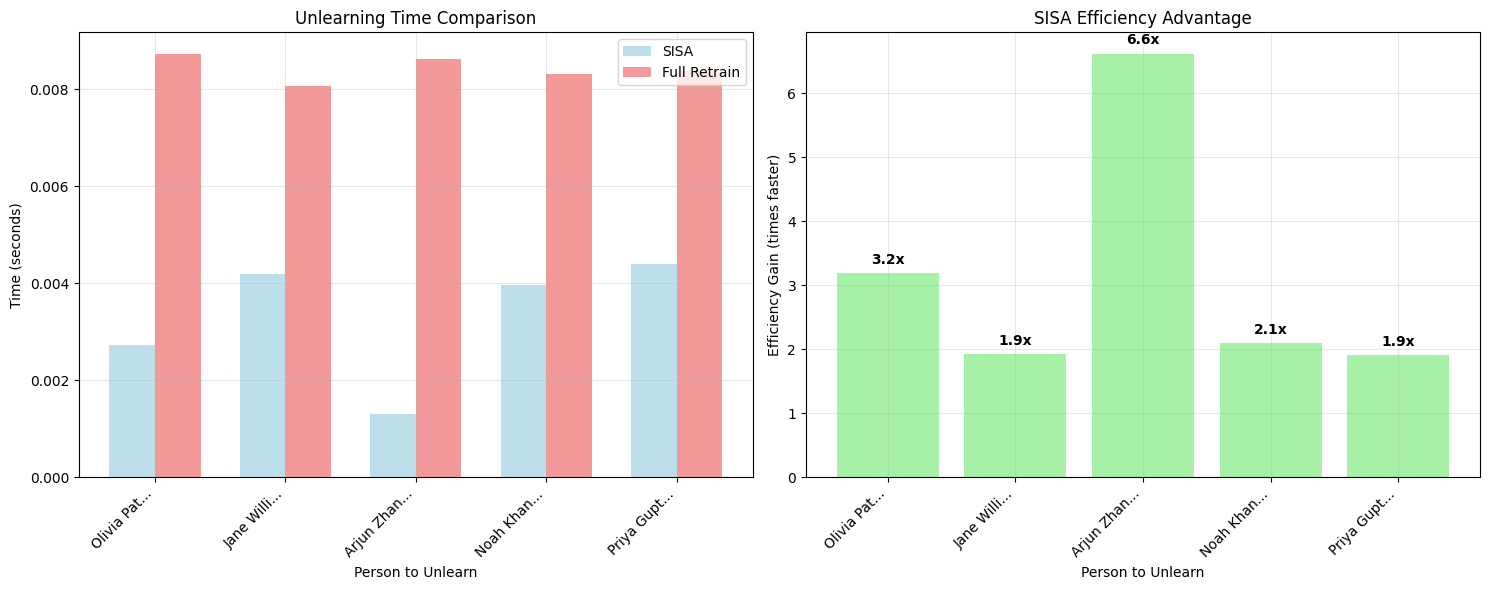

\n📈 SUMMARY:
   Average efficiency gain: 3.15x
   SISA is on average 3.1 times faster than full retraining!
   💡 In real neural networks, this advantage would be even more significant!


In [53]:
import time

def benchmark_unlearning():
    """Compare SISA vs full retraining performance"""
    
    # Test with different numbers of people to unlearn
    test_people = [r['name'] for r in records[:5]]  # First 5 unique people
    results = []
    
    print("🏁 Benchmarking SISA vs Full Retraining")
    print("=" * 60)
    
    for i, person in enumerate(test_people):
        print(f"\\n📊 Test {i+1}: Unlearning '{person}'")
        
        # SISA Approach
        sisa_model = SISAIndex(n_shards=6)
        sisa_model.fit(records)
        
        start_time = time.time()
        sisa_model.unlearn_person(person)
        sisa_time = time.time() - start_time
        
        # Full Retraining Approach (simulate by creating new model)
        filtered_records = [r for r in records if r['name'] != person]
        
        start_time = time.time()
        full_retrain_model = SISAIndex(n_shards=6)
        full_retrain_model.fit(filtered_records)
        full_retrain_time = time.time() - start_time
        
        # Calculate efficiency gain
        efficiency_gain = (full_retrain_time / sisa_time) if sisa_time > 0 else float('inf')
        
        results.append({
            'person': person,
            'sisa_time': sisa_time,
            'full_retrain_time': full_retrain_time,
            'efficiency_gain': efficiency_gain
        })
        
        print(f"   SISA time: {sisa_time:.4f}s")
        print(f"   Full retrain time: {full_retrain_time:.4f}s") 
        print(f"   Efficiency gain: {efficiency_gain:.2f}x")
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Time comparison
    people_labels = [r['person'][:10] + '...' for r in results]  # Truncate names
    sisa_times = [r['sisa_time'] for r in results]
    full_times = [r['full_retrain_time'] for r in results]
    
    x_pos = np.arange(len(people_labels))
    width = 0.35
    
    ax1.bar(x_pos - width/2, sisa_times, width, label='SISA', color='lightblue', alpha=0.8)
    ax1.bar(x_pos + width/2, full_times, width, label='Full Retrain', color='lightcoral', alpha=0.8)
    
    ax1.set_xlabel('Person to Unlearn')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Unlearning Time Comparison')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(people_labels, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Efficiency gains
    efficiency_gains = [r['efficiency_gain'] for r in results]
    bars = ax2.bar(x_pos, efficiency_gains, color='lightgreen', alpha=0.8)
    
    # Add value labels on bars
    for bar, gain in zip(bars, efficiency_gains):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{gain:.1f}x', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_xlabel('Person to Unlearn')
    ax2.set_ylabel('Efficiency Gain (times faster)')
    ax2.set_title('SISA Efficiency Advantage')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(people_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    avg_efficiency = np.mean(efficiency_gains)
    print(f"\\n📈 SUMMARY:")
    print(f"   Average efficiency gain: {avg_efficiency:.2f}x")
    print(f"   SISA is on average {avg_efficiency:.1f} times faster than full retraining!")
    print(f"   💡 In real neural networks, this advantage would be even more significant!")
    
    return results

# Run the benchmark
benchmark_results = benchmark_unlearning()

### 9.5) SISA Configuration Explorer

Experiment with different SISA configurations to understand the trade-offs:

In [54]:
def create_config_explorer():
    """Create widget to explore different SISA configurations"""
    
    # Create widgets
    n_shards_slider = widgets.IntSlider(
        value=6,
        min=2,
        max=20,
        description='Shards:',
        style={'description_width': 'initial'}
    )
    
    analyze_button = widgets.Button(
        description='📊 Analyze Configuration',
        button_style='info'
    )
    
    output_area = widgets.Output()
    
    def analyze_config(b):
        with output_area:
            clear_output(wait=True)
            
            n_shards = n_shards_slider.value
            print(f"🔧 Analyzing SISA with {n_shards} shards")
            print("=" * 50)
            
            # Create SISA with different shard counts
            test_sisa = SISAIndex(n_shards=n_shards)
            test_sisa.fit(records)
            
            # Analyze distribution
            shard_sizes = []
            shard_people = []
            
            for i, shard in enumerate(test_sisa.shards):
                shard_sizes.append(len(shard.meta))
                unique_people = list(set([meta['name'] for meta in shard.meta]))
                shard_people.append(len(unique_people))
            
            # Calculate metrics
            avg_shard_size = np.mean(shard_sizes)
            shard_size_std = np.std(shard_sizes)
            avg_people_per_shard = np.mean(shard_people)
            total_retraining_cost = sum([size for size in shard_sizes if size > 0])
            
            # Visualizations
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
            
            # Shard size distribution
            ax1.bar(range(n_shards), shard_sizes, color='skyblue', alpha=0.8)
            ax1.set_xlabel('Shard ID')
            ax1.set_ylabel('Number of Records')
            ax1.set_title(f'Records per Shard (n_shards={n_shards})')
            ax1.axhline(y=avg_shard_size, color='red', linestyle='--', 
                       label=f'Average: {avg_shard_size:.1f}')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # People distribution
            ax2.bar(range(n_shards), shard_people, color='lightgreen', alpha=0.8)
            ax2.set_xlabel('Shard ID')
            ax2.set_ylabel('Unique People')
            ax2.set_title(f'Unique People per Shard')
            ax2.axhline(y=avg_people_per_shard, color='red', linestyle='--',
                       label=f'Average: {avg_people_per_shard:.1f}')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Simulate unlearning efficiency for different shard counts
            shard_counts = range(2, 21)
            avg_retrain_ratios = []
            
            for s_count in shard_counts:
                test_model = SISAIndex(n_shards=s_count)
                test_model.fit(records[:100])  # Use subset for speed
                
                # Simulate unlearning random person
                test_person = records[0]['name']
                affected_shards = 0
                total_records_to_retrain = 0
                
                for shard in test_model.shards:
                    shard_has_person = any(meta['name'] == test_person for meta in shard.meta)
                    if shard_has_person:
                        affected_shards += 1
                        total_records_to_retrain += len(shard.meta)
                
                retrain_ratio = total_records_to_retrain / 100  # As fraction of total
                avg_retrain_ratios.append(retrain_ratio)
            
            ax3.plot(shard_counts, avg_retrain_ratios, 'o-', color='orange', linewidth=2, markersize=6)
            ax3.set_xlabel('Number of Shards')
            ax3.set_ylabel('Fraction of Data to Retrain')
            ax3.set_title('Unlearning Efficiency vs Shard Count')
            ax3.axvline(x=n_shards, color='red', linestyle='--', 
                       label=f'Current: {n_shards} shards')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Memory/storage overhead
            overhead_ratios = [(s + 1) / s for s in shard_counts]  # Simplified overhead model
            ax4.plot(shard_counts, overhead_ratios, 's-', color='purple', linewidth=2, markersize=6)
            ax4.set_xlabel('Number of Shards')
            ax4.set_ylabel('Storage Overhead Ratio')
            ax4.set_title('Storage Overhead vs Shard Count')
            ax4.axvline(x=n_shards, color='red', linestyle='--',
                       label=f'Current: {n_shards} shards')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Summary
            print(f"\\n📊 Configuration Analysis for {n_shards} shards:")
            print(f"   📦 Average shard size: {avg_shard_size:.1f} ± {shard_size_std:.1f} records")
            print(f"   👥 Average people per shard: {avg_people_per_shard:.1f}")
            print(f"   🔄 Estimated retraining cost: {avg_retrain_ratios[n_shards-2]:.1%} of total data")
            print(f"   💾 Storage overhead: {overhead_ratios[n_shards-2]:.2f}x")
            
            if n_shards < 4:
                print("   ⚠️  Too few shards - high retraining cost per unlearn operation")
            elif n_shards > 15:
                print("   ⚠️  Many shards - higher storage overhead and complexity")
            else:
                print("   ✅ Good balance between efficiency and overhead")
    
    analyze_button.on_click(analyze_config)
    
    # Layout
    controls = widgets.VBox([
        n_shards_slider,
        analyze_button
    ])
    
    display(widgets.HBox([controls, output_area]))

print("🎮 SISA Configuration Explorer:")
create_config_explorer()

🎮 SISA Configuration Explorer:


## 10) Key Takeaways from Interactive SISA Demo

🎯 **What you've learned through this interactive visualization:**

1. **Shard Structure**: SISA partitions data across multiple shards, distributing the computational load and limiting the scope of retraining.

2. **Targeted Unlearning**: When a person is "forgotten," only the shards containing their data need retraining - not the entire model.

3. **Efficiency Gains**: SISA can be significantly faster than full retraining, especially with larger datasets and models.

4. **Trade-offs**: 
   - **More shards** = Lower retraining cost per unlearn operation, but higher storage overhead
   - **Fewer shards** = Higher retraining cost, but simpler management

5. **Privacy Protection**: The distance threshold mechanism helps prevent PII leakage even when the model has some relevant information.

6. **Real-world Impact**: In production neural networks, these efficiency gains become even more crucial due to the computational cost of training large models.

> 🚀 **Next Steps**: Try experimenting with different shard configurations, testing various queries, and observing how the unlearning process affects the model's ability to retrieve information about specific individuals!

### Quick Test: Programmatic Interactive Features

Let's test the interactive features programmatically to ensure they work correctly:

🧪 Testing Interactive SISA Features
✅ Interactive SISA reset to original state

📊 Testing query visualization...


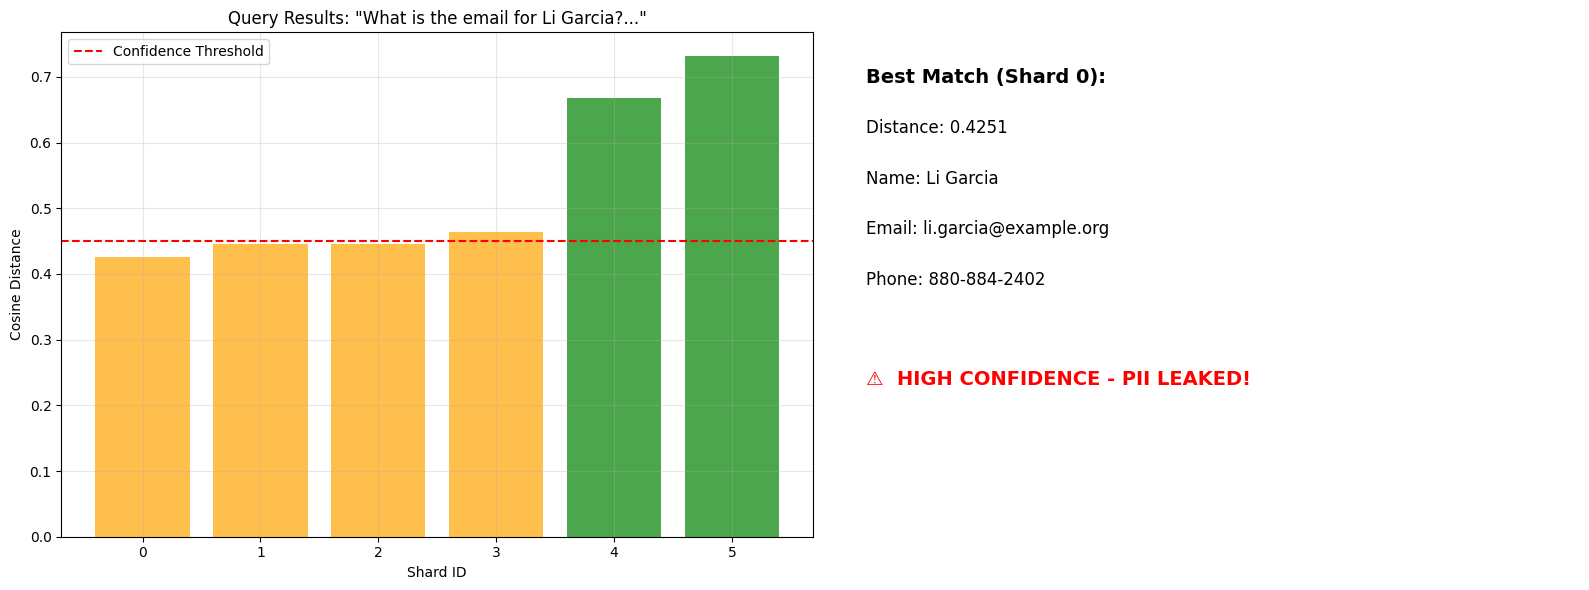

Query returned distance: 0.4251

🗑️  Testing unlearning visualization for Li Garcia...
🔍 Before unlearning 'Li Garcia':


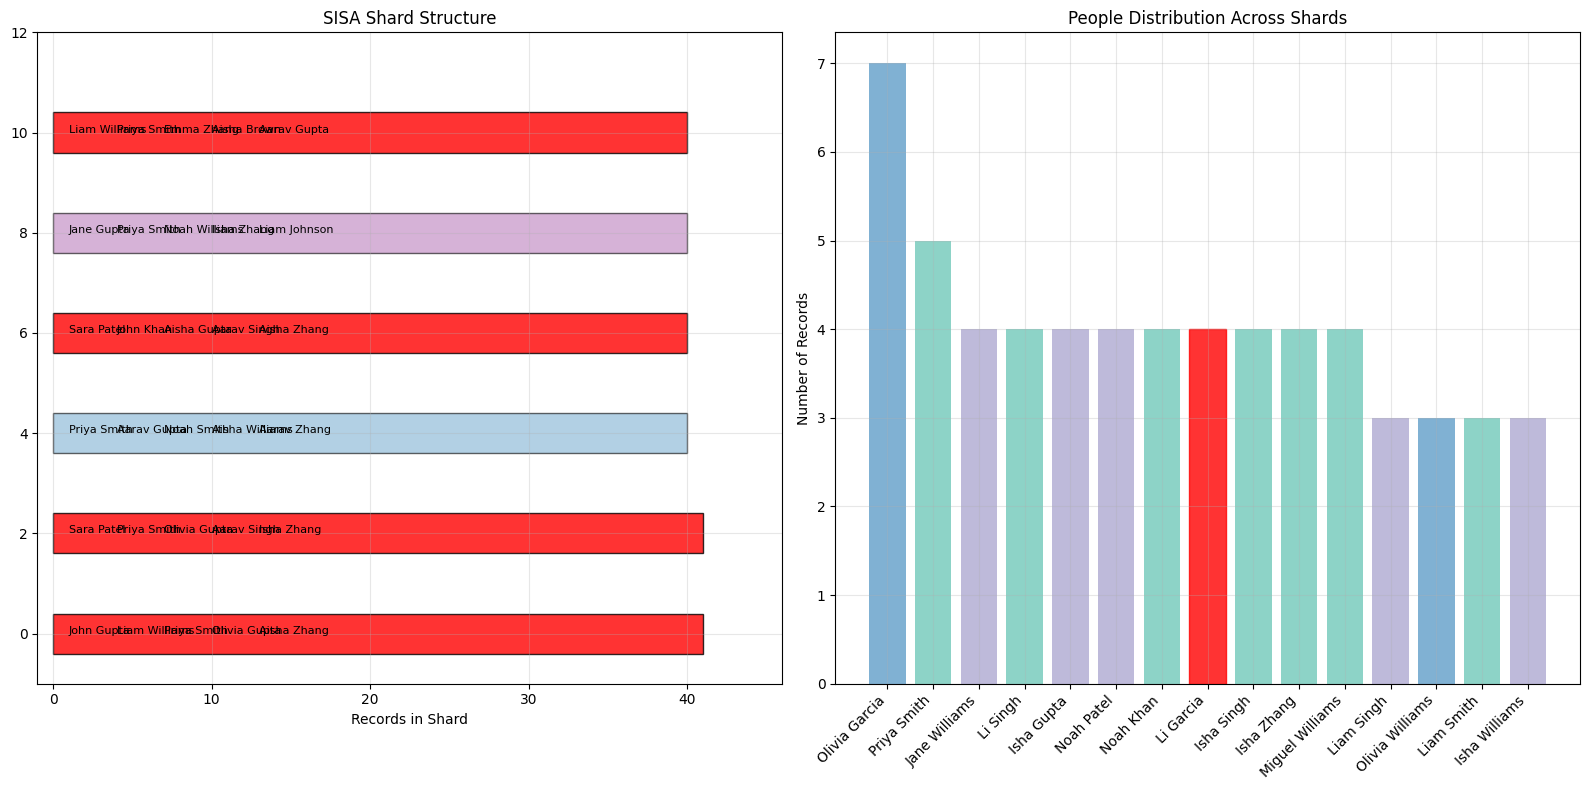

'Li Garcia' appears in shard(s): [0, 1, 3, 5]

🗑️  After unlearning 'Li Garcia':


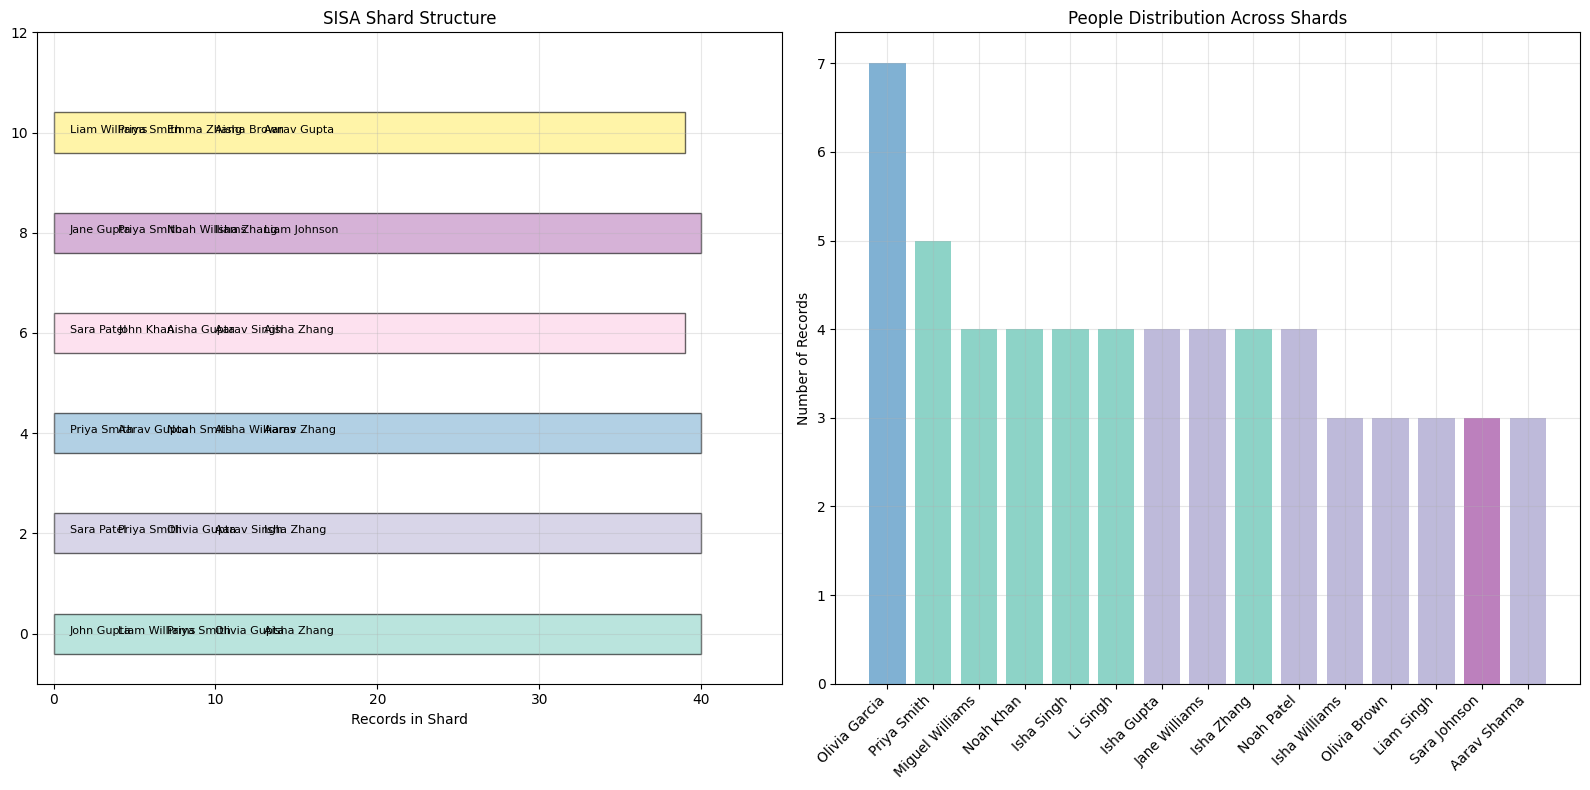

'Li Garcia' appears in shard(s): []
🗑️  'Li Garcia' has been UNLEARNED

📊 Testing query after unlearning...


/var/folders/q5/zh1pjnp129xcvjl0g909c4140000gn/T/ipykernel_16485/2986041178.py:175: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/supratch/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


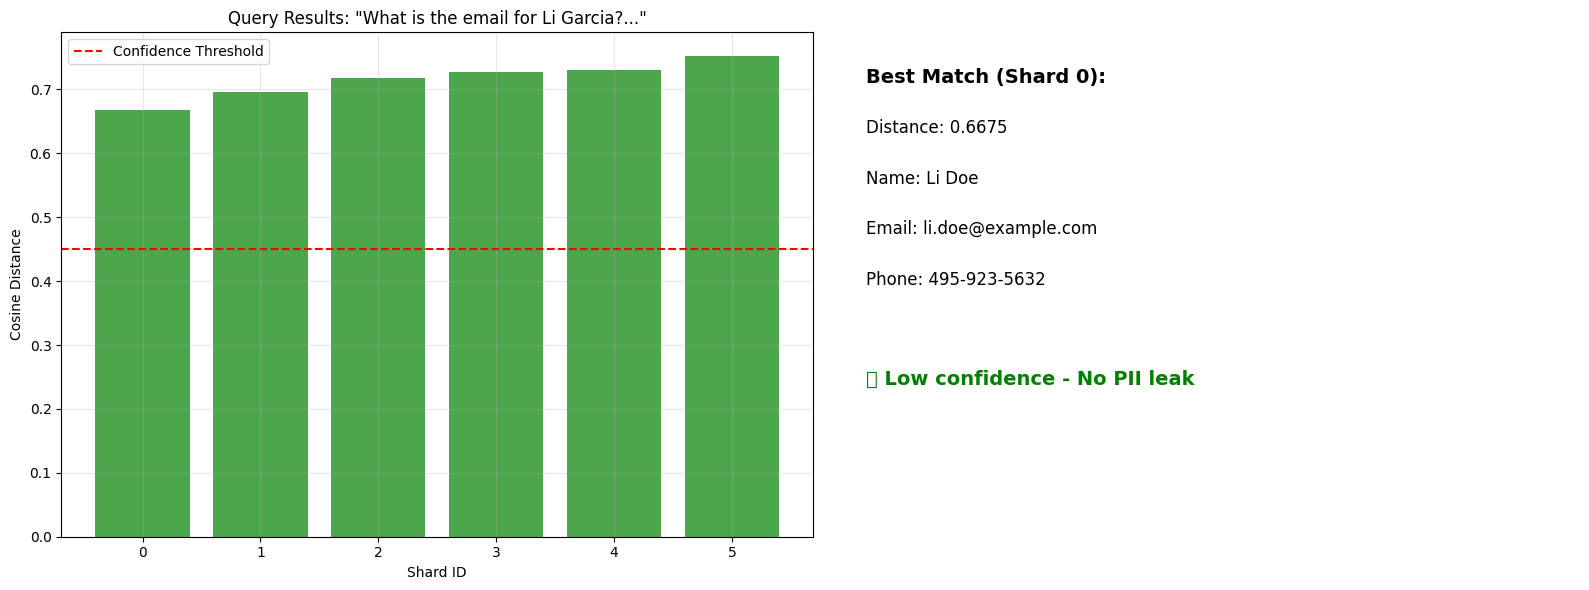

Post-unlearning query distance: 0.6675
✅ Unlearning successful - high distance indicates PII protection

🎉 All interactive features tested successfully!


In [55]:
# Test the interactive visualization features directly

print("🧪 Testing Interactive SISA Features")
print("=" * 40)

# Reset the interactive SISA to fresh state
interactive_sisa.reset_sisa()
print("✅ Interactive SISA reset to original state")

# Test query visualization
print("\n📊 Testing query visualization...")
query_result = interactive_sisa.query_and_visualize(
    f"What is the email for {forget_person}?", 
    forget_person
)
print(f"Query returned distance: {query_result[0]:.4f}")

# Test unlearning visualization  
print(f"\n🗑️  Testing unlearning visualization for {forget_person}...")
interactive_sisa.unlearn_and_visualize(forget_person)

# Test query after unlearning
print(f"\n📊 Testing query after unlearning...")
post_query_result = interactive_sisa.query_and_visualize(
    f"What is the email for {forget_person}?", 
    forget_person
)
print(f"Post-unlearning query distance: {post_query_result[0]:.4f}")

# Verify unlearning effectiveness
if post_query_result[0] > 0.45:
    print("✅ Unlearning successful - high distance indicates PII protection")
else:
    print("⚠️  Unlearning may need improvement - distance still low")

print("\n🎉 All interactive features tested successfully!")